In [6]:
!git clone https://github.com/herm23/Project-NNDL.git

Cloning into 'Project-NNDL'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (3/3), done.


In [7]:
%cd Project-NNDL/

/content/Project-NNDL/Project-NNDL


Link per il datset di CompCar (trovato su sito ufficiale): https://drive.google.com/drive/folders/18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg


In [8]:
!pip install -U -q PyDrive

Import necessari

In [9]:
from pydrive2.auth import GoogleAuth
from pydrive2.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import os

Scarico i dati direttamente dal drive pubblico

In [10]:
#Autenticazione
auth.authenticate_user()

gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [11]:
# Estrazione dei dati dalla cartella
# ID della cartella pubblica
folder_id = '18EunmjOJsbE5Lh9zA0cZ4wKV6Um46dkg'

# Cartella locale per salvare i dati
save_path = '/content/Project-NNDL/compcar_dataset'
os.makedirs(save_path, exist_ok=True)

# Lista file nella cartella Drive
file_list = drive.ListFile({'q': f"'{folder_id}' in parents and trashed=false"}).GetList()

# Scarica tutti i file
for file in file_list:
    print(f"Scaricando {file['title']}")
    file.GetContentFile(os.path.join(save_path, file['title']))



Scaricando sv_data.zip
Scaricando sv_data.z03
Scaricando sv_data.z02
Scaricando sv_data.z01
Scaricando data.zip
Scaricando data.z22
Scaricando data.z21
Scaricando data.z20
Scaricando data.z19
Scaricando data.z18
Scaricando data.z17
Scaricando data.z16
Scaricando data.z15
Scaricando data.z14
Scaricando data.z13
Scaricando data.z12
Scaricando data.z11
Scaricando data.z10
Scaricando data.z09
Scaricando data.z08
Scaricando data.z07
Scaricando data.z06
Scaricando data.z05
Scaricando data.z04
Scaricando data.z03
Scaricando data.z02
Scaricando data.z01
Scaricando README.txt


In [12]:
!apt-get install -y p7zip-full


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-8).
0 upgraded, 0 newly installed, 0 to remove and 35 not upgraded.


In [13]:
%cd /content/Project-NNDL/compcar_dataset

/content/Project-NNDL/compcar_dataset


password per unzippare: d89551fd190e38

In [14]:
!7z x data.zip -o./compcar_dataset/unzipped


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 391417395 bytes (374 MiB)

Extracting archive: data.zip
  1% 4096 Open               39% 131072 Open                 75% 249856 Open                --
Path = data.zip
Type = zip
Physical Size = 391417395
Embedded Stub Size = 4
64-bit = +
Total Physical Size = 16539487795
Multivolume = +
Volume Index = 22
Volumes = 23

  0%    
Enter password (will not be echoed):
  0% 5 - data/image/1/1101/2011/07b90decb92ba6.jpg                                                    0% 98 - data/image/1/1107/2011/81b72c79de4955.jpg

In [68]:
from torchvision.transforms import ToTensor
import torchvision
import torch
import os
import pandas as pd
import h5py
import random
import numpy as np

seed = 0
random.seed(seed)
torch.manual_seed(seed)
np.random.seed(seed)

In [62]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # tutte le immagini diventano 224x224
    transforms.ToTensor(),
])

Dataset (label = maker)

In [63]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os
import scipy.io as sio

class CarMakerDataset(Dataset):
    def __init__(self, image_root, mat_path, transform=None):
        """
        image_root: path a 'image/' (che contiene make_id/.../image.jpg)
        mat_path: path a 'make_model_name.mat'
        transform: trasformazioni PyTorch
        """
        self.image_root = image_root
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}

        # Carica la lista dei make_id -> make_name
        mat = sio.loadmat(mat_path)
        make_names = [name[0] for name in mat['make_names'][0]]

        # Crea mapping: make_id (1-based) → make_name
        self.make_id_to_name = {i+1: make_names[i] for i in range(len(make_names))}

        # Crea mapping: make_name → label index
        for idx, name in enumerate(sorted(set(make_names))):
            self.class_to_idx[name] = idx
            self.idx_to_class[idx] = name

        # Costruisce lista di immagini e le etichette (maker)
        for make_id_str in sorted(os.listdir(image_root)):
            make_path = os.path.join(image_root, make_id_str)
            if not os.path.isdir(make_path):
                continue
            make_id = int(make_id_str)

            if make_id not in self.make_id_to_name:
                continue  # Skip se non è nel .mat

            maker_name = self.make_id_to_name[make_id]
            label = self.class_to_idx[maker_name]

            # Cerca ricorsivamente immagini
            for root, _, files in os.walk(make_path):
                for file in files:
                    if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        img_path = os.path.join(root, file)
                        self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [64]:
img = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
maker_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'

train_dataset =  CarMakerDataset(img, maker_path, transform)

batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

Guardo un immagine

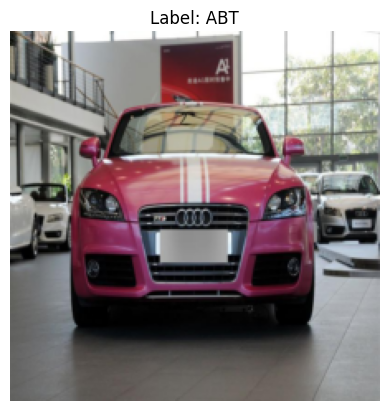

In [65]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

img, label = train_dataset[0]
plt.imshow(F.to_pil_image(img))
plt.title(f"Label: {train_dataset.idx_to_class[label]}")
plt.axis('off')
plt.show()

Rete Neurale...CNN su contrastive feature

# Contrastive Learning

In [45]:
class ContrastiveTransformations(object):

    def __init__(self, base_transforms, n_views=2):
        self.base_transforms = base_transforms
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transforms(x) for i in range(self.n_views)]

In [87]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # tutte le immagini diventano 224x224
    transforms.RandomHorizontalFlip(p=0.5), # Horizontal flip
    transforms.RandomResizedCrop(size=96),  # Random crop
    transforms.RandomApply([transforms.ColorJitter(0.5, 0.5, 0.5, 0.1)], p=0.8),  # Color distorsion
    transforms.RandomGrayscale(p=0.2), # Random grayscale
    transforms.GaussianBlur(kernel_size=9),  # Gaussian blur
    transforms.ToTensor(),
])

In [88]:
img = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/image'
maker_path = '/content/Project-NNDL/compcar_dataset/compcar_dataset/unzipped/data/misc/make_model_name.mat'

train_dataset =  CarMakerDataset(img, maker_path, transform=ContrastiveTransformations(transform, n_views=2))

In [79]:
batch_size = 64
train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True)

torch.Size([12, 3, 96, 96])


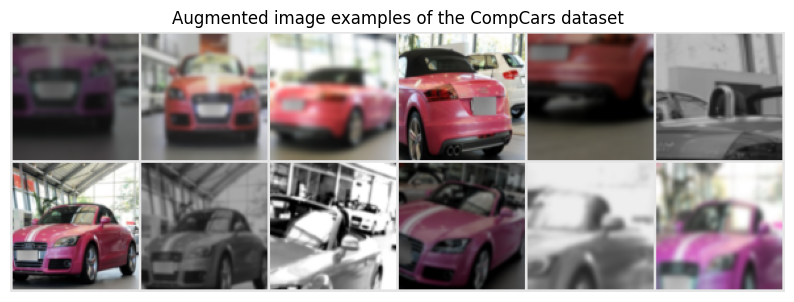

In [89]:
# Visualize some examples
NUM_IMAGES = 6
imgs = torch.stack([img for idx in range(NUM_IMAGES) for img in train_dataset[idx][0]], dim=0)
print(imgs.shape)


img_grid = torchvision.utils.make_grid(imgs, nrow=6, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)
plt.figure(figsize=(10,5))
plt.title('Augmented image examples of the CompCars dataset')
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

rete resnet (ancora da definire)

In [90]:
from torch.nn import Module, Sequential, Conv2d, BatchNorm2d, ReLU

class MainPath(Module):

    def __init__(self, in_channels, filters, kernel_size, stride=1):
        super().__init__()
        F1, F2, F3 = filters
        self.main_path = Sequential(
            Conv2d(in_channels, F1, kernel_size=1, stride=stride),
            BatchNorm2d(F1),
            ReLU(),
            Conv2d(F1, F2, kernel_size=kernel_size, padding=kernel_size//2),
            BatchNorm2d(F2),
            ReLU(),
            Conv2d(F2, F3, kernel_size=1),
            BatchNorm2d(F3),
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.main_path(x)
        return y

class IdentityBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size)
        self.relu = ReLU()

    def forward(self, x):
        y = self.relu(self.main_path(x) + x)
        return y

class ConvolutionalBlock(MainPath):

    def __init__(self, in_channels, filters, kernel_size):
        super().__init__(in_channels, filters, kernel_size, stride=2)
        self.relu = ReLU()
        self.shortcut_path = Sequential(
            Conv2d(in_channels, filters[2], kernel_size=1, stride=2),
            BatchNorm2d(filters[2])
        )
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()

    def forward(self, x):
        y = self.relu(self.main_path(x) + self.shortcut_path(x))
        return y

forse basta resnetx con x<50

In [91]:
from torch.nn import MaxPool2d, AvgPool2d, Linear, Dropout
class ResNet50(Module):

    def __init__(self):
        super().__init__()
        self.network = Sequential(
            Conv2d(3, 64, kernel_size=7, stride=2),
            BatchNorm2d(64),
            MaxPool2d(kernel_size=3, stride=2),
            ConvolutionalBlock(64, [64, 64, 256], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            IdentityBlock(256, [64, 64, 256], kernel_size=3),
            ConvolutionalBlock(256, [128, 128, 512], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            IdentityBlock(512, [128, 128, 512], kernel_size=3),
            ConvolutionalBlock(512, [256, 256, 1024], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            IdentityBlock(1024, [256, 256, 1024], kernel_size=3),
            ConvolutionalBlock(1024, [512, 512, 2048], kernel_size=3),
            Dropout(0.2),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            IdentityBlock(2048, [512, 512, 2048], kernel_size=3),
            AvgPool2d(kernel_size=2, stride=2)
        )
        self.classification_layer = Linear(2048, 1)
        self.apply(self._init_weights)

    def forward(self, x):
        y = self.network(x).reshape((x.shape[0], -1))
        y = self.classification_layer(y)
        return y

    def _init_weights(self, module):
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Conv2d):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()


In [93]:
import torch
import torch.nn as nn
class SimCLR(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.convnet = ResNet50(hidden_dim)
        self.projection_head = nn.Sequential(
            nn.ReLU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )

    def forward(self, x):
        features = self.convnet(x)
        out = self.projection_head(features)
        return out

loss

train

# Rete CNN (su feaure di rete contrastive)

In [ ]:
class Classifier(nn.Module):

    def __init__(self, feature_dim, num_classes):
        super().__init__()

        # Mapping from representation h to classes with a linear layer
        self.model = nn.Linear(feature_dim, num_classes)

    def forward(self, x):
        return self.model(x)

Continual learning
---

